In [1]:
import os
import sys
import numpy as np
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from RxDesign.designUtil import cut_polygon_by_line, generate_continue_region, generate_split_line, find_nearest_point
import matplotlib.pyplot as plt
from shapely.geometry import shape
import json
from util import read_sensing_info, plotPolygons, plotLines
from osgeo import gdal
from scipy.ndimage import binary_dilation
from shapely.geometry import LineString
import matplotlib.pyplot as plt
import mplcursors
from ipywidgets import *
from shapely.ops import linemerge
from shapely.geometry import LineString

In [2]:
# NLCD
wf_filename = "/Volumes/Shield/WFRxTradeoffs/data/GRSM_MAIN_WF.json"
with open(wf_filename) as f:
    data = json.load(f)
polygon = shape(data["perimeter"])


nlcd_file = "/Volumes/Shield/WFRxTradeoffs/data/geo_static/NLCD_Clipped.tif"
nlcd_ds = gdal.Open(nlcd_file, gdal.GA_ReadOnly)
nlcd_value = nlcd_ds.ReadAsArray()
nlcd_info = read_sensing_info(nlcd_ds)
lon, lat = nlcd_info["crs"](nlcd_info["X"], nlcd_info["Y"], inverse=True)
nlcd_value = nlcd_value.astype(float)
# change nlcd_value to mask
nlcd_value[(nlcd_value > 32) | (nlcd_value < 11)] = 0
nlcd_value[(nlcd_value < 32) & (nlcd_value >= 11)] = 1

# # dilation the image
# k = np.ones((3, 3), dtype=int)
# nlcd_value = nlcd_value.astype(int)
# nlcd_value = binary_dilation(nlcd_value == 0, k) & nlcd_value

<ipython-input-3-f80f56ae6774>:5: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(lon, lat, nlcd_value)


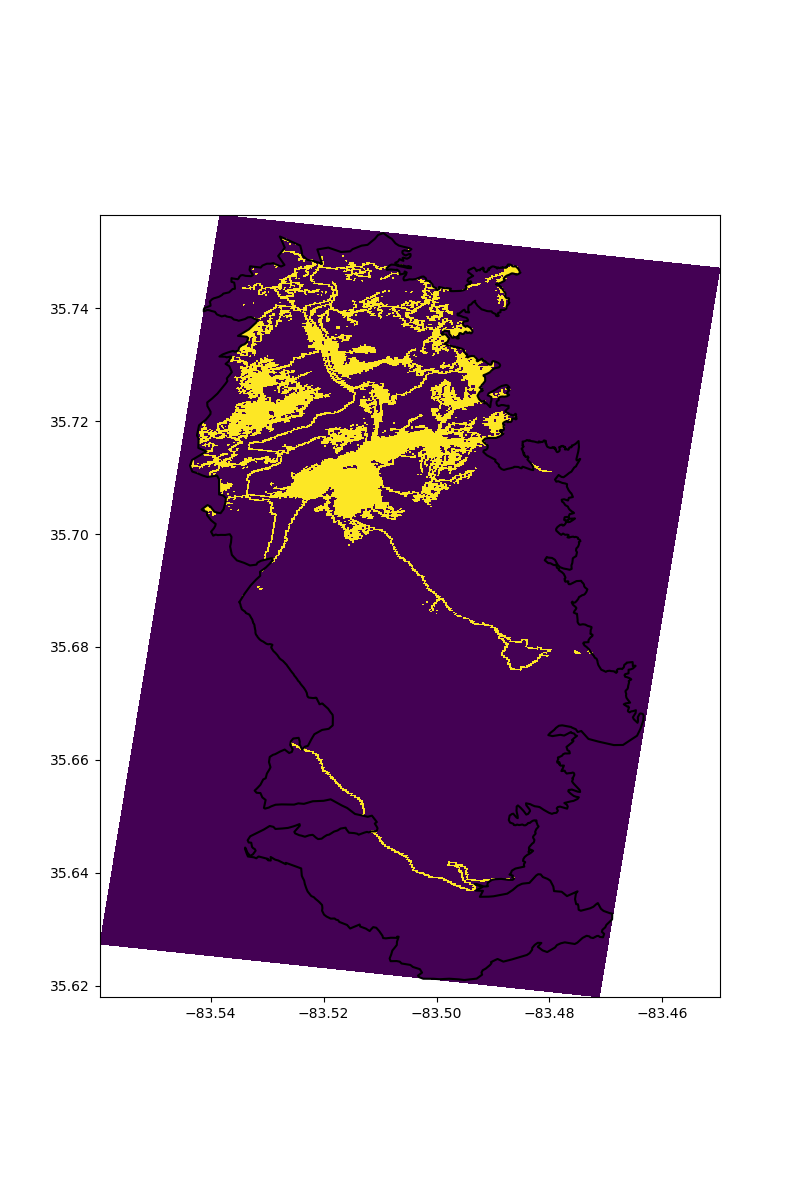

In [3]:
%matplotlib widget
fig, ax = plt.subplots(figsize=(8, 12))
lines_end_points = []
# wildfire
plt.pcolor(lon, lat, nlcd_value)
plotPolygons([polygon], ax, "black")
ax.ticklabel_format(style='plain', useOffset=False)


def on_click(event):
    # Get the x and y coordinates of the click
    x_click = event.xdata
    y_click = event.ydata
    
    # Add the clicked point to the plot
    ax.scatter([x_click], [y_click], c='r', s=3)
    lines_end_points.append((x_click, y_click))
    # Refresh the plot
    fig.canvas.draw()

ax.set_aspect('equal')
# Connect the event handler to the figure
fig.canvas.mpl_connect('button_press_event', on_click)

# Show the interactive plot
plt.show()

In [4]:
print(lines_end_points)

[(-83.52674052759981, 35.66412874269211), (-83.5127463911646, 35.64924890141921)]


In [5]:
lines = []
# use the end points to create lines
for i in range(0, len(lines_end_points) - 1):
    start_point = lines_end_points[i]
    end_point = lines_end_points[i + 1]
    start_lon = start_point[0]
    start_lat = start_point[1]
    end_lon = end_point[0]
    end_lat = end_point[1]
    
    # find the start and end point
    start_x_idx, start_y_idx = find_nearest_point(start_lon, start_lat, lon, lat, nlcd_value)
    end_x_idx, end_y_idx = find_nearest_point(end_lon, end_lat, lon, lat, nlcd_value)
    cur_line_res = generate_split_line(start_x_idx, start_y_idx, end_x_idx, end_y_idx, lon, lat, nlcd_value)
    if cur_line_res is None:
        print("A not continuous path")
        cur_line_res = LineString([(lon[start_x_idx, start_y_idx], lat[start_x_idx, start_y_idx]),
                                  (lon[end_x_idx, end_y_idx], lat[end_x_idx, end_y_idx])])
    # add head and tail, this part order is important
    if i == 0:
        lines.append(LineString([(start_lon, start_lat),
                                  (lon[start_x_idx, start_y_idx], lat[start_x_idx, start_y_idx])]))
    lines.append(cur_line_res)
    if i == (len(lines_end_points) - 2):
        lines.append(LineString([(lon[end_x_idx, end_y_idx], lat[end_x_idx, end_y_idx]), 
                                 (end_lon, end_lat)]))
merged_line = linemerge(lines)

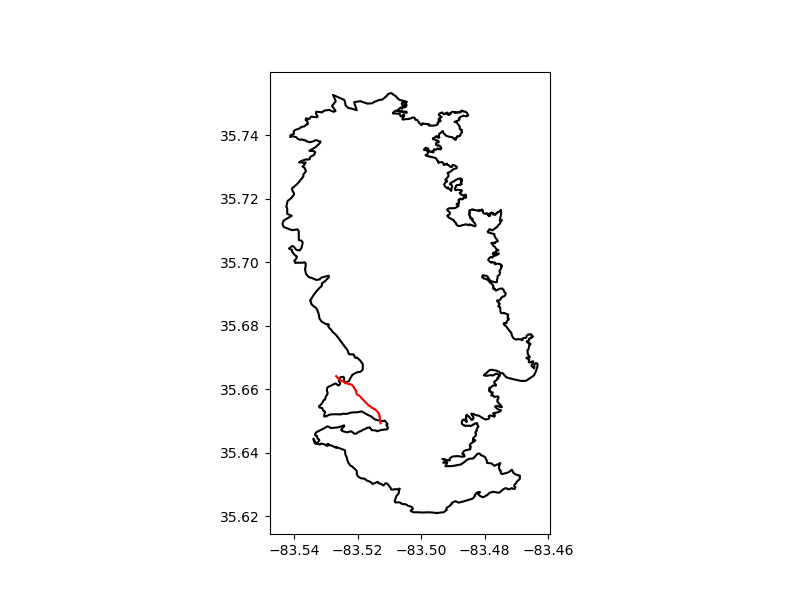

In [7]:
# visualize line
fig, ax = plt.subplots(figsize=(8, 6))
plotPolygons([polygon], ax, 'black')
plotLines([merged_line], ax, 'red')
ax.set_aspect('equal')
plt.show()

In [7]:
print(merged_line)

LINESTRING (-83.51186068632693 35.648186055614, -83.51147954244932 35.64742710029751, -83.51119197862114 35.64712632507146, -83.51090441706336 35.64682554907269, -83.51061685777596 35.64652477230124, -83.51032930075893 35.64622399475707, -83.51004174601222 35.64592321644027, -83.50975419353584 35.6456224373508, -83.50946664332974 35.64532165748864, -83.50917909539393 35.64502087685378, -83.50889154972836 35.6447200954463, -83.50856020041635 35.64468497417173, -83.50827265846161 35.64438419117892, -83.50794131089566 35.64434906816449, -83.50765377265168 35.64404828358645, -83.50732242683182 35.64401315883215, -83.50703489229858 35.64371237266886, -83.50670354822479 35.64367724617476, -83.50641601740229 35.64337645842628, -83.50608467507459 35.64334133019226, -83.50579714796278 35.64304054085856, -83.50550962312106 35.64273975075231, -83.50522210054939 35.64243895987328, -83.50493458024779 35.6421381682217, -83.50464706221621 35.64183737579742, -83.50469088013898 35.64157171570962, -83.5

In [8]:
import pickle
# save the line
filename = "/Users/zongrunli/Desktop/Wildfire_GA/RxDesign/temp_lines/line_11.pickle"
res = {"line": merged_line}
with open(filename, 'wb') as handle:
    pickle.dump(res, handle, protocol=pickle.HIGHEST_PROTOCOL)